In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


# Recreate AMS Grad Results

In [2]:
class AdamOptimizer(tf.train.Optimizer):
    def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
        self.learning_rate = learning_rate
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.var_list = var_list
        self.m = {}
        self.v = {}
        self.beta1_t = tf.Variable(1.0, trainable=False)
        self.beta2_t = tf.Variable(1.0, trainable=False)
        self.t = tf.Variable(0.0, trainable=False)
    
        for var in self.var_list:
            self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
            self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
    def apply_gradients(self, gradient_variables):
        beta1_t = self.beta1_t.assign(self.beta1_t * self.beta1)
        beta2_t = self.beta2_t.assign(self.beta2_t * self.beta2)
    
        with tf.control_dependencies([self.t.assign_add(1.0), beta1_t, beta2_t]):
            learning_rate = self.learning_rate
            if self.decay:
                learning_rate /= tf.sqrt(self.t)
            update_ops = []

            for (g, var) in gradient_variables:
                m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
                v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
                m_hat = m / (1 - beta1_t)
                v_hat = v / (1 - beta2_t)

                update = -learning_rate * m_hat / (self.epsilon + tf.sqrt(v_hat))
                update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)

In [3]:
class AMSGradOptimizer(tf.train.Optimizer):
    def __init__(self, learning_rate=0.001, decay=False, beta1=0.9, beta2=0.99,
               epsilon=0.0, var_list=[]):
        self.learning_rate = learning_rate
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.var_list = var_list
        self.m = {}
        self.v = {}
        self.v_hat = {}
        self.t = tf.Variable(0.0, trainable=False)
    
        for var in self.var_list:
            self.m[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
            self.v[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
            self.v_hat[var] = tf.Variable(tf.zeros(tf.shape(var.initial_value)), trainable=False)
    
    def apply_gradients(self, gradient_variables):
        with tf.control_dependencies([self.t.assign_add(1.0)]):
            learning_rate = self.learning_rate
            if self.decay:
                learning_rate /= tf.sqrt(self.t)
                update_ops = []

        for (g, var) in gradient_variables:
            m = self.m[var].assign(self.beta1 * self.m[var] + (1 - self.beta1) * g)
            v = self.v[var].assign(self.beta2 * self.v[var] + (1 - self.beta2) * g * g)
            v_hat = self.v_hat[var].assign(tf.maximum(self.v_hat[var], v))

            update = -learning_rate * m / (self.epsilon + tf.sqrt(v_hat))
            update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)

In [4]:
def test_optimizer(optimizer_name, iterations=1000000, learning_rate=0.001,
                   decay=False):
    tf.reset_default_graph()
  
    with tf.Session() as sess:
        r = tf.distributions.Bernoulli(probs=0.01, dtype=tf.float32).sample()
        x = tf.Variable(0.0)
        loss = (r * 1010 - (1 - r) * 10) * x
        var_list = [x]
        gradient = tf.gradients(loss, var_list)

        if optimizer_name == "adam":
            optimizer = AdamOptimizer(var_list=var_list, learning_rate=learning_rate,
                                    decay=decay)
        elif optimizer_name == "amsgrad":
            optimizer = AMSGradOptimizer(var_list=var_list, learning_rate=learning_rate,
                                       decay=decay)
        else:
            raise Exception("Unknown optimizer")

        update_op = optimizer.apply_gradients([(grad, var) for grad, var in zip(gradient, var_list)])
        with tf.control_dependencies([update_op]):
            clip_op = x.assign(tf.clip_by_value(x, -1.0, 1.0))

        sess.run(tf.global_variables_initializer())

        results = []

        for i in range(iterations):
            _, cur_x = sess.run([clip_op, x])
            results.append(cur_x)

            if i % 500000 == 0:
                print(cur_x)

        return results

In [5]:
results_adam = test_optimizer("adam", iterations=50000, learning_rate=0.5,
                              decay=True)

0.49999967


In [6]:
results_amsgrad = test_optimizer("amsgrad", iterations=100000, learning_rate=0.5,
                                 decay=True)

0.50000006


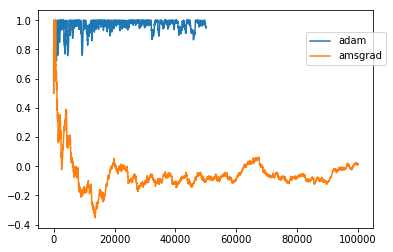

In [7]:
plt.plot(results_adam, label="adam")
plt.plot(results_amsgrad, label="amsgrad")
plt.legend(bbox_to_anchor=(0.8, 0.9), loc=2, borderaxespad=0.)
plt.show()